In [1]:
import pandas as pd 
import numpy as np 

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
madelon_df = pd.read_csv("madelon.csv")

In [5]:
madelon_df = madelon_df.iloc[:,1:].copy()

In [6]:
madelon_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V491,V492,V493,V494,V495,V496,V497,V498,V499,V500
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511


In [7]:
madelon_df.shape

(2600, 500)

In [8]:
# Check for the null values 
sum(madelon_df.isna().sum() > 0)

0

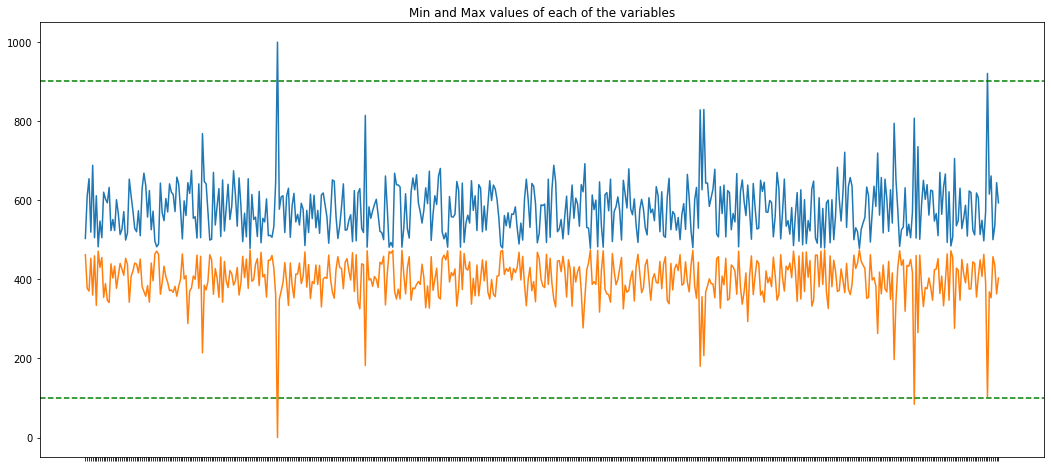

In [40]:
plt.figure(figsize=(18,8))
sns.lineplot(madelon_df.max())
sns.lineplot(madelon_df.min())
plt.title("Min and Max values of each of the variables")
plt.axhline(y = 900, color = "g", linestyle = "--")
plt.axhline(y = 100, color = "g", linestyle = "--")
plt.xticks(visible = False);

###### 1.1 What preprocessing techniques did you apply, if any?

I normalized the data -> the scale of columns impact the mean of centroids and hence impact the clusters themselfs 

I also check for null values and drop them before doing k means

I also check for outliers that are extreme that may influence my k means model

I am not doing the feature selection or Dimensionality reduction to the data for now as we will do that later in the question 

###### 1.2 Describe qualitatively: how does the number of clusters affect the performance of the clustering algorithm on the dataset? 

Number of clusters impact the algorithm significantly - 

If the k is small, the resulting groups are large and are generalized (too broad to be practically put under one cluster) and do not capture the subtle differences among those values.

If the k is large, the resulting groups are small and within variation decreases decreasing the total sse. But as the K increses to n (number of observations) there is only one value for a cluster and the resulting clusters are non-insightful 



###### 1.3 Generate a plot of the number of clusters k (x-axis) versus the sum of squared distance (SSE) between data points and their assigned centroids (y-axis). What appears to be the optimal k from the list of values you used, and why? 

In [10]:
madelon_scaled = StandardScaler().fit_transform(madelon_df)

In [11]:
k_list = [4, 8, 16, 32, 64]

In [12]:
def run_kmeans(df, k, rstate, init_val = 'random'):
    kmeans_model = KMeans(n_clusters=k, random_state=rstate, init=init_val)

    kmeans_model.fit(df)
    
    return kmeans_model

In [13]:
model_details = pd.DataFrame(columns=['k', 'sse', 'silhouette_score'])
for _ in k_list:
    model = run_kmeans(madelon_scaled, _, 4)
    sse_val = model.inertia_
    Silhouette_Score = silhouette_score(madelon_scaled,model.labels_)
    print("Ran for K =",_, f"The model has an sse of {round(sse_val,2)} and Silhouette score of {round(Silhouette_Score,4)}")
    data_dict = {"k":_,
                "sse": sse_val,
                 "silhouette_score": Silhouette_Score}
    
    model_details = pd.concat([model_details,pd.DataFrame(data_dict, index=[0])],ignore_index=True, axis = 0) 
    
    

Ran for K = 4 The model has an sse of 1277782.38 and Silhouette score of 0.0057
Ran for K = 8 The model has an sse of 1268384.82 and Silhouette score of 0.0037
Ran for K = 16 The model has an sse of 1260345.37 and Silhouette score of 0.0023
Ran for K = 32 The model has an sse of 1250586.26 and Silhouette score of -0.0001
Ran for K = 64 The model has an sse of 1232586.12 and Silhouette score of -0.0091


In [14]:
model_details

,k,sse,silhouette_score
0,4,1277782.383028,0.00567
1,8,1268384.815286,0.003712
2,16,1260345.371172,0.002286
3,32,1250586.258396,-0.000074
4,64,1232586.119151,-0.00909


######  What appears to be the optimal k from the list of values you used, and why? 

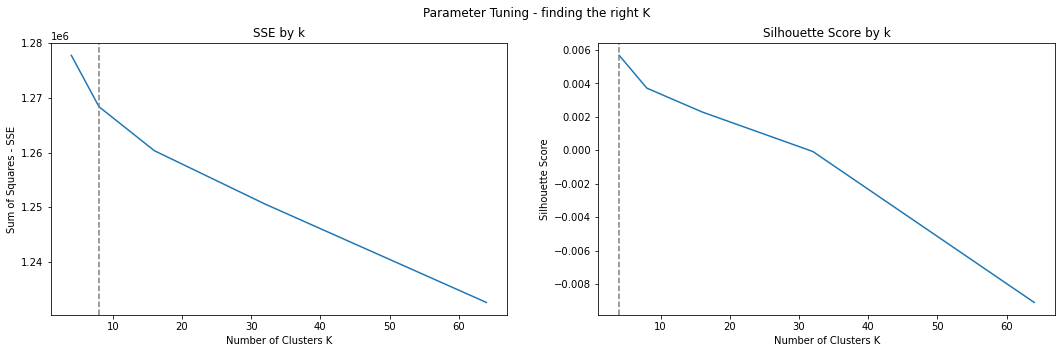

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18,5))

sns.lineplot(data=model_details,x='k',y='sse', ax=ax1)
ax1.set_title("SSE by k")
ax1.axvline(x=8, color='gray', linestyle='--')
ax1.set_xlabel("Number of Clusters K")
ax1.set_ylabel("Sum of Squares - SSE")

sns.lineplot(data=model_details,x='k',y='silhouette_score', ax=ax2)
ax2.set_title("Silhouette Score by k")
ax2.axvline(x=4, color='gray', linestyle='--')
ax2.set_xlabel("Number of Clusters K")
ax2.set_ylabel("Silhouette Score")

plt.suptitle("Parameter Tuning - finding the right K");



###### K = 8

From the elbow method from the above the most reasonabe k is 8. For both the SSE and Silhouette methods there is significant dip in metrics from k = 4 to k = 8 and the drop is pretty much constant. For those reasons we can consider the k-value of 8 to be optimal. So increasing the k value furthur may not be a good balance between model performance and computational expense

###### 1.4 For k = 8, how did you initialize the set of cluster centroids before running k-means? Rerun k-means again, this time ensuring that the centroids are all different. Does this – and if so, to what extent – affect the final clusters created?

Let's look at the initial centroinds and the new centroids with k-means++ initiation for clusters 

In [16]:
# random assignment 

model_k8_random = run_kmeans(madelon_scaled,k =8,rstate=4)

pd.DataFrame(model_k8_random.cluster_centers_).mean(axis=1)

0    0.015527
1   -0.007490
2    0.002436
3    0.000724
4    0.008123
5    0.007046
6   -0.011808
7   -0.011493
dtype: float64

In [17]:
# initial cluster assignment with K-means++

model_k8_kpp = run_kmeans(madelon_scaled,k =8,rstate=4,init_val='k-means++')

pd.DataFrame(model_k8_kpp.cluster_centers_).mean(axis=1)

0   -0.007656
1    0.011725
2    0.003411
3   -0.010611
4    0.001479
5   -0.005651
6   -0.012165
7    0.008536
dtype: float64

In [18]:
print("SSE and Silhouette score for new model is ",round(model_k8_kpp.inertia_,2), 
      "and", round(silhouette_score(madelon_scaled,model_k8_kpp.labels_), 4),"respectively")

SSE and Silhouette score for new model is  1268280.36 and 0.0035 respectively


The initail models see and Silhoutte score are 1268384.82 and 0.0037 which is suboptimal to the ne model's sse and silhouette of 1268280.36 and 0.0035 respectively

The final clusters depend on the initial assignment of the clusters. The model takes more or less time to converge and form different clusters depending on the random initial assignment. 

selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. It helps speeding up the convergance 

##### 1.5 More generally for any dataset, what evaluation metrics can be used to assess the quality of the clusters produced?

One can use the following metrics to quatify and compare the model performance 

1. SSE - Sum of Squares Error - the lowest is the best
2. Silhouette Score - The highest is the best 
3. Davies-Bouldin Index - Average similarity between each cluster - The lowest is the best 
4. Adjusted Mutual Information - Measures the mutual information - The higher the value the better it is

###### 2.1 Fit the standardized data with PCA. Then, create a cumulative variance plot – showing the number of components included (x-axis) versus the amount of variance captured (y-axis). Generally, we want to retain at least 75% of the variance. How many components would you decide to keep?

###### 2.2 Perform PCA with your selected principal components.

In [19]:
def plot_pca(var_exp,var_exp_cum,name_cols):
    plt.figure(figsize = (15,6))
    plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(var_exp_cum)), var_exp_cum, where='mid',label='Cumulative explained variance')
    plt.scatter(x=277,y=.75,marker = "*")
    plt.text(270,.70,"(277 PCs at 0.75 varience explained)",color = "red")
    plt.axhline(y=.75, color='gray', linestyle='--')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.title(name_cols)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [20]:
def pca_run(df,name_cols = "All Cols -",cols = ["All"]):
    
    col_list = list(df.columns)
    
    if cols[0] != "All":
        df = df[cols].copy()
    
    st_df = StandardScaler().fit_transform(df)
    pca = PCA(.75)

    principalComponents = pca.fit_transform(st_df)

    count_pcs = principalComponents.shape[1]

    colnames_pc = ["PC" + str(x) for x in range(1,count_pcs+1)]

    principalDf = pd.DataFrame(data = principalComponents, columns= colnames_pc)
    
    loadings = pd.DataFrame(pca.components_[:2,:], columns= col_list)
    
    pca_2 = PCA()
    pca_2.fit(st_df)

    exp_var = pd.Series(pca_2.explained_variance_ratio_)
    exp_var_cs = exp_var.cumsum()

    plot_pca(exp_var,exp_var_cs,name_cols)
    
    return (principalDf,loadings)

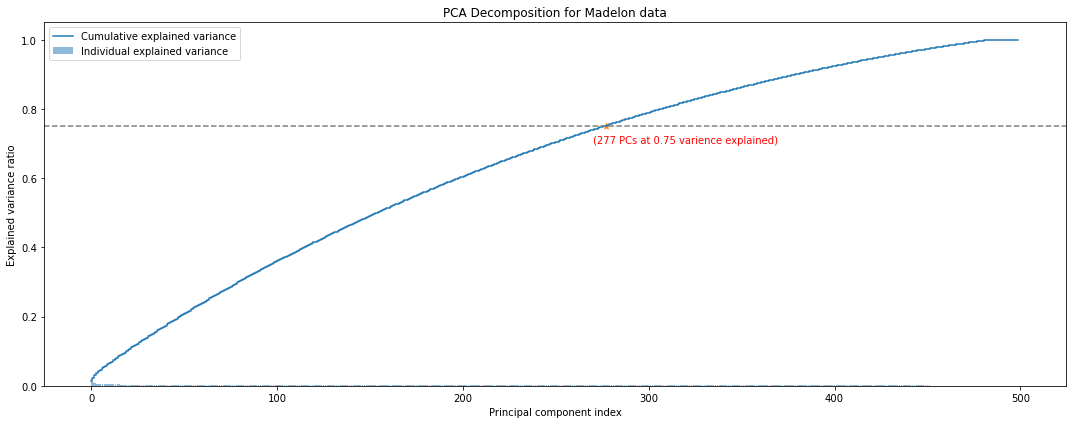

In [21]:
pcout = pca_run(madelon_df, name_cols= "PCA Decomposition for Madelon data")

In [22]:
principalDF = pcout[0]
loadings = pcout[1]

In [23]:
principalDF.shape

(2600, 277)

We need to consider the first 277 principal companents to explain 75% of the variation in data

###### 2.2.1 Plot the transformed data on a graph with the first two principal components as the axes i.e. x = PC 1, y = PC 2

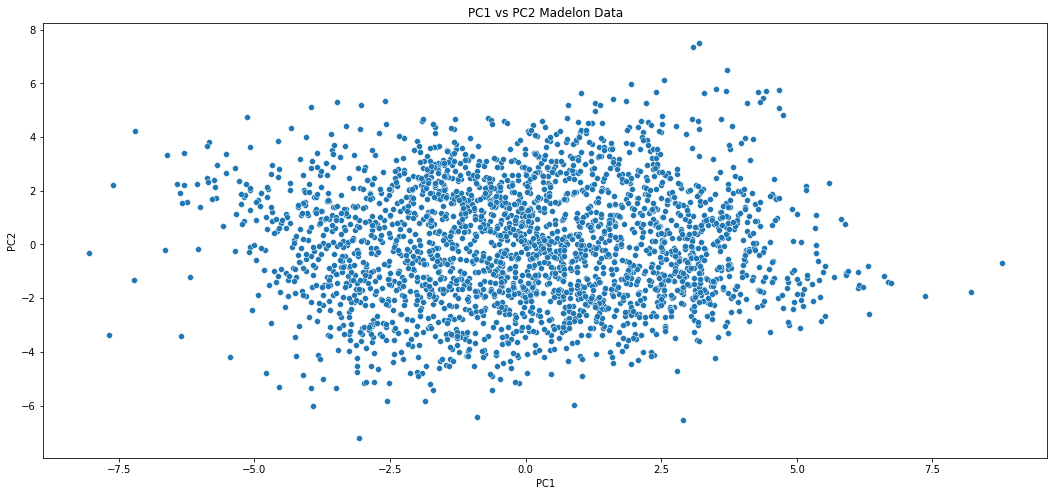

In [24]:
fig, ax = plt.subplots(figsize = (18,8))
sns.scatterplot(data=principalDF,x = "PC1", y = "PC2")
ax.set_title("PC1 vs PC2 Madelon Data");

###### 2.2.2 Plot the original data on a graph with the two original variables that have the highest absolute combined loading for PC 1 and PC 2 i.e. maximizing |loading PC1| + |loading PC2|.

In [25]:
# Highest loading on the first PC and second PC

(abs(loadings.T[0]) + abs(loadings.T[1])).sort_values(ascending=False).head(2)

V339    0.488970
V282    0.450537
dtype: float64

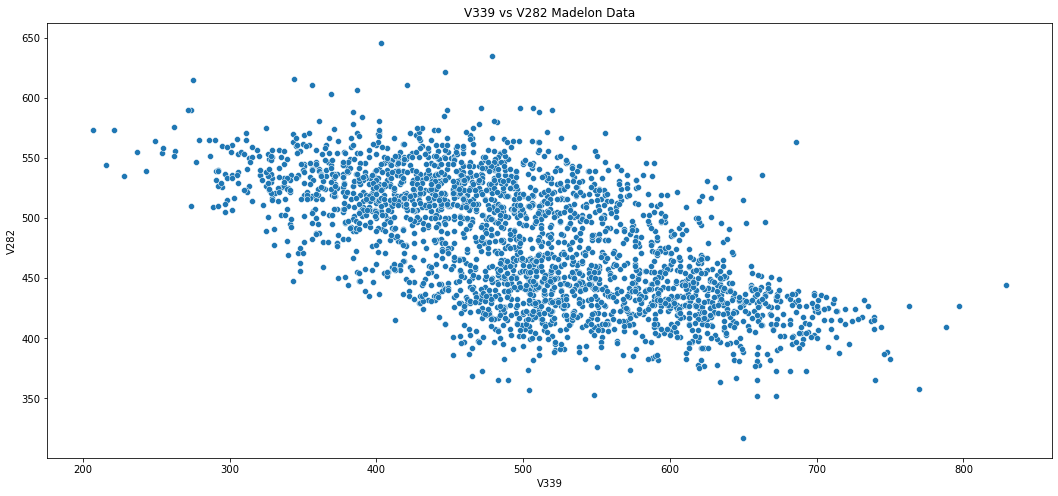

In [26]:
fig, ax = plt.subplots(figsize = (18,8))
sns.scatterplot(data=madelon_df.loc[:,['V339','V282']],x = "V339", y = "V282")
ax.set_title("V339 vs V282 Madelon Data");

###### 2.3 Examine the scatter plot of PC 1 (x-axis) versus PC 2 (y-axis) for all data points that you created in the previous part. Qualitatively, can you identify visible clusters? Why or why not might this be the case with this particular dataset?

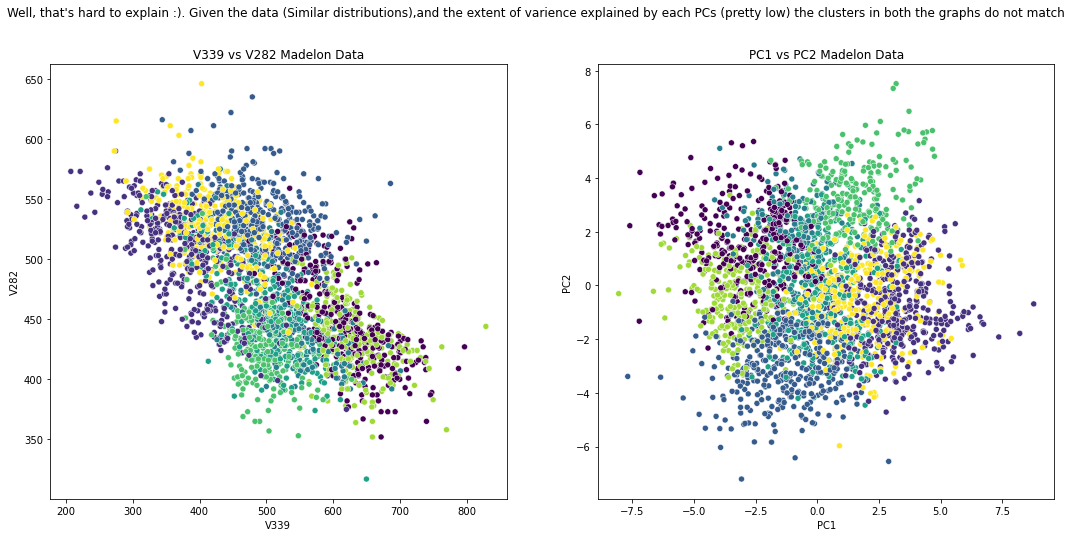

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2 , figsize = (18,8))
sns.scatterplot(data=madelon_df.loc[:,['V339','V282']],x = "V339", y = "V282", c = model_k8_kpp.labels_, ax=ax1)
ax1.set_title("V339 vs V282 Madelon Data")
sns.scatterplot(data=principalDF,x = "PC1", y = "PC2", c = model_k8_kpp.labels_, ax=ax2)
ax2.set_title("PC1 vs PC2 Madelon Data")
plt.suptitle("Well, that's hard to explain :). Given the data (Similar distributions),"+ 
             "and the extent of varience explained by each PCs (pretty low) the clusters in both the graphs do not match");



The original components have two major visible clusters - one towards the top-left and the one towards the bottom-right (Even though this is not very clearly visible. However the PCs do not have any visible clusters. 

###### It is interesting how the clusters in the data "look" completely different.

If you look closely you would observe the clusters in both the graphs are kinda similar -> the one from PCs are just rotated ~170 degrees clock-wise. That is just the PCA doing its "thing" :)

So yeah V339 and V282 more or less influence highest variation of the PC1 and PC2 - obviously because they have the highest loadings to PC1 and PC2. 

###### This is completely reasonable give the nature of the data 

Our data is distributed in a similar fashion. All the variables are in the same range and the data looks random. With the extent of the variation explained by PC1 and PC2 there are no "visible" clusters in the PC graph.

###### 3.   Now, we will run k-means clustering on the transformed data from the previous problem.

###### 3.1 Why is it a good idea to do this, especially for high-dimensional datasets? Name a number of reasons.

###### The Curse of Dimentionality 

1. Distance Concentration - > Given the high dimensional data, the distances and the similarity metrics are not qualitatively relevant in the higher dimensions; we need to reduce the dimensions with the least loss in information possible 


2. PCA removes noise in data -> only keeps relevant information 
    

3. Processing time and computational resourses - > High dimentional data requires a lot of computational resourses with little to no extra information 


###### 3.2 Use the same k values again (4, 8, 16, 32, 64) to again generate an elbow plot. 

In [28]:
model_details_new = pd.DataFrame(columns=['k', 'sse', 'silhouette_score'])
for _ in k_list:
    model = run_kmeans(principalDF, _, 4)
    sse_val = model.inertia_
    Silhouette_Score = silhouette_score(principalDF,model.labels_)
    print("Ran for K =",_, f"The model has an sse of {round(sse_val,2)} and Silhouette score of {round(Silhouette_Score,4)}")
    data_dict = {"k":_,
                "sse": sse_val,
                 "silhouette_score": Silhouette_Score}
    
    model_details_new = pd.concat([model_details_new,pd.DataFrame(data_dict, index=[0])],ignore_index=True, axis = 0) 
    
    

Ran for K = 4 The model has an sse of 953016.16 and Silhouette score of 0.0077
Ran for K = 8 The model has an sse of 943919.76 and Silhouette score of 0.0054
Ran for K = 16 The model has an sse of 935658.3 and Silhouette score of 0.0039
Ran for K = 32 The model has an sse of 926311.06 and Silhouette score of 0.0024
Ran for K = 64 The model has an sse of 911365.19 and Silhouette score of -0.0089


In [29]:
model_details

,k,sse,silhouette_score
0,4,1277782.383028,0.00567
1,8,1268384.815286,0.003712
2,16,1260345.371172,0.002286
3,32,1250586.258396,-0.000074
4,64,1232586.119151,-0.00909


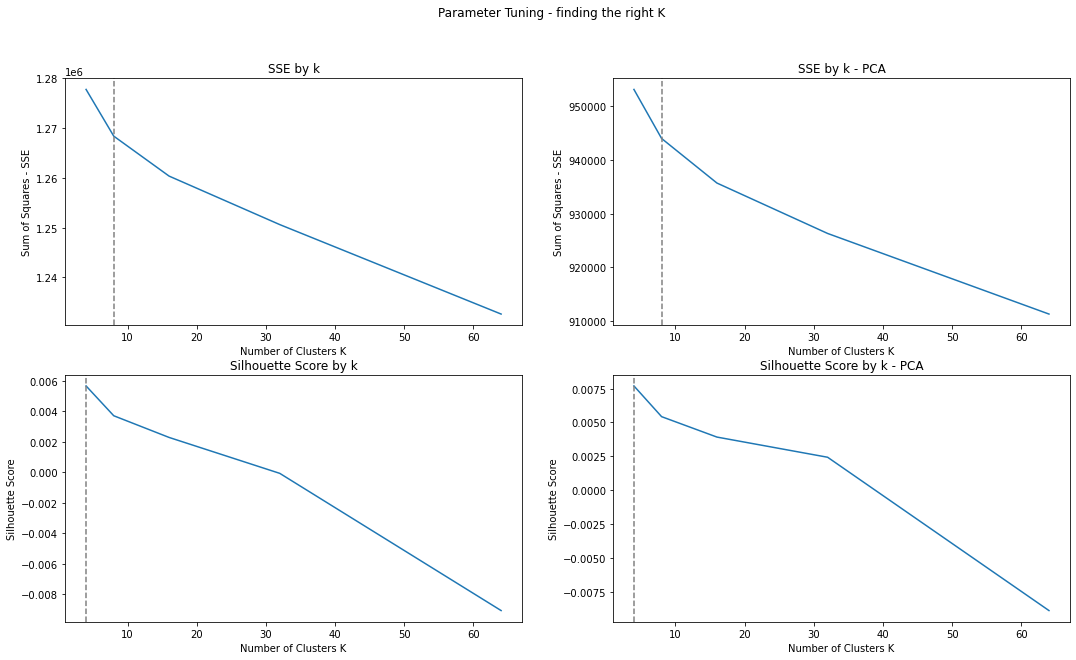

In [30]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (18,10))

sns.lineplot(data=model_details,x='k',y='sse', ax=ax1)
ax1.set_title("SSE by k")
ax1.axvline(x=8, color='gray', linestyle='--')
ax1.set_xlabel("Number of Clusters K")
ax1.set_ylabel("Sum of Squares - SSE")

sns.lineplot(data=model_details_new,x='k',y='sse', ax=ax2)
ax2.set_title("SSE by k - PCA")
ax2.axvline(x=8, color='gray', linestyle='--')
ax2.set_xlabel("Number of Clusters K")
ax2.set_ylabel("Sum of Squares - SSE")

sns.lineplot(data=model_details,x='k',y='silhouette_score', ax=ax3)
ax3.set_title("Silhouette Score by k")
ax3.axvline(x=4, color='gray', linestyle='--')
ax3.set_xlabel("Number of Clusters K")
ax3.set_ylabel("Silhouette Score")

sns.lineplot(data=model_details_new,x='k',y='silhouette_score', ax=ax4)
ax4.set_title("Silhouette Score by k - PCA")
ax4.axvline(x=4, color='gray', linestyle='--')
ax4.set_xlabel("Number of Clusters K")
ax4.set_ylabel("Silhouette Score")

plt.suptitle("Parameter Tuning - finding the right K");



###### 3.2.1 What is the optimal k? Is it different from the one you found in (1)?

It doesn't look like there is a difference in the optimal K the "elbow" graphs seems very similar 


###### 3.2.2 Compare the SSE values plotted in this exercise to the previous plot you generated in (1c) before performing PCA.

In [31]:
###### 4    1277782.383028 # 4    953016.164317
###### 8    1268384.815286 # 8    943919.760998
###### 16   1260345.371172 # 16   935658.298852
###### 32   1250586.258396 # 32   926311.056249
###### 64   1232586.119151 # 64   911365.18978

The sse decreased a lot in general for all the k values in the model with important PCs. This is obvious because now we reduced the dimensions the values are closer now than before :) 

In [32]:
model_k8_kpp_pc = run_kmeans(principalDF, 8, 4,init_val="k-means++")

###### Again, create a scatter plot of PC 1 (x-axis) versus PC 2 (y-axis) for all of the transformed data points. Label the cluster centers and color-code by cluster assignment for the first 5 iterations of k = 32. Can you see the algorithm begin to converge to optimal assignments?

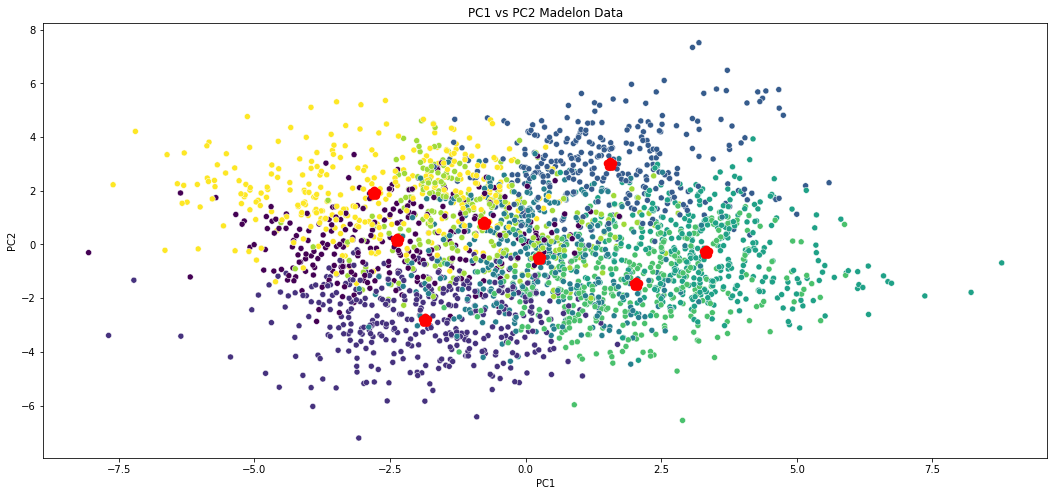

In [33]:
fig, ax = plt.subplots(figsize = (18,8))
sns.scatterplot(data=principalDF,x = "PC1", y = "PC2", c = model_k8_kpp_pc.labels_)
plt.scatter(model_k8_kpp_pc.cluster_centers_[:, 0], model_k8_kpp_pc.cluster_centers_[:, 1], marker='*', linewidths=8, color='r')
ax.set_title("PC1 vs PC2 Madelon Data");

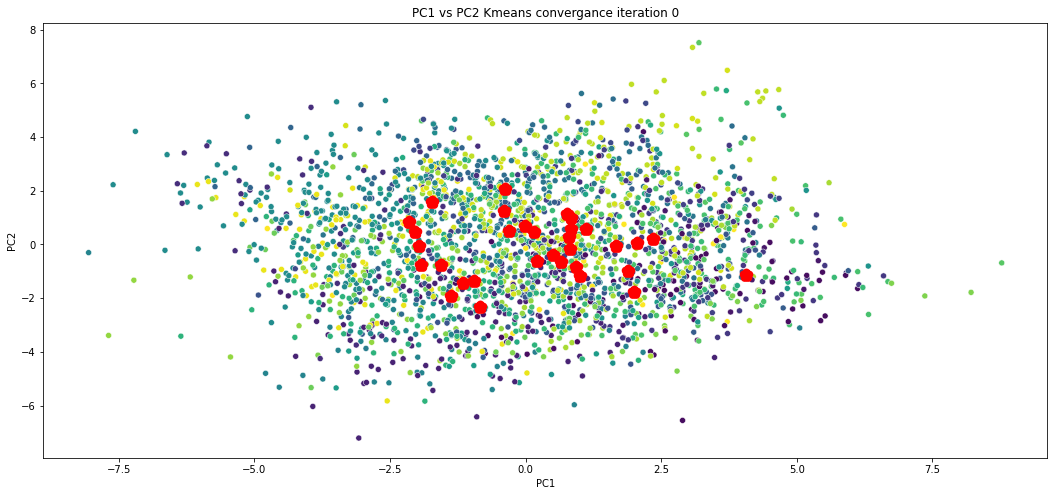

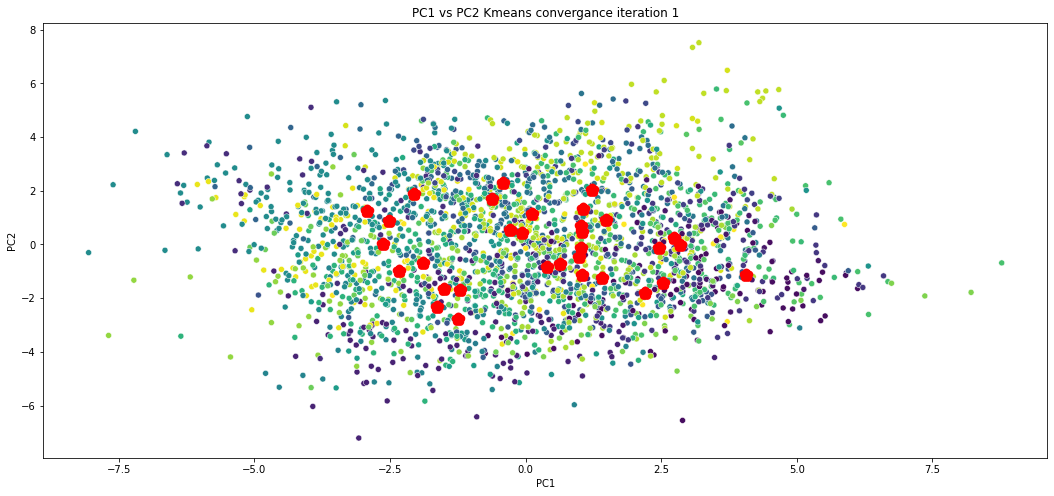

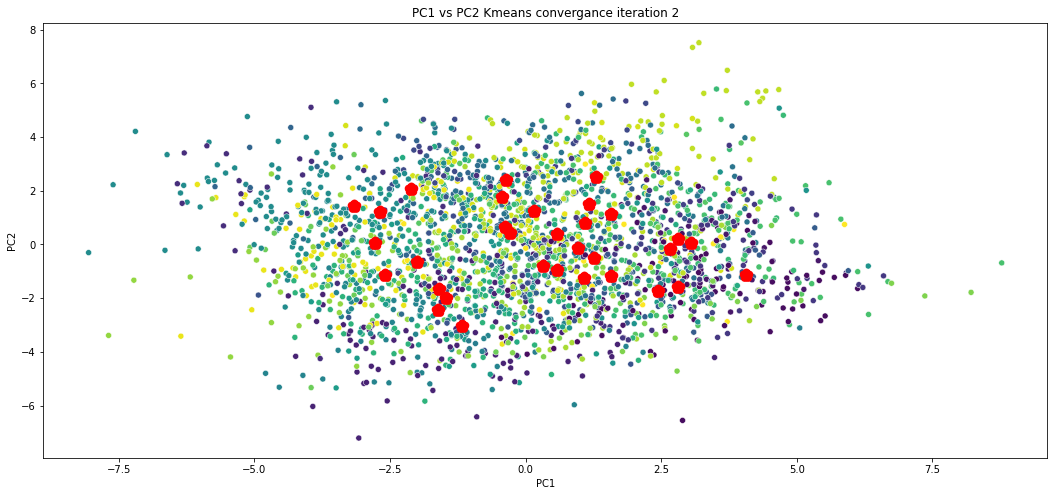

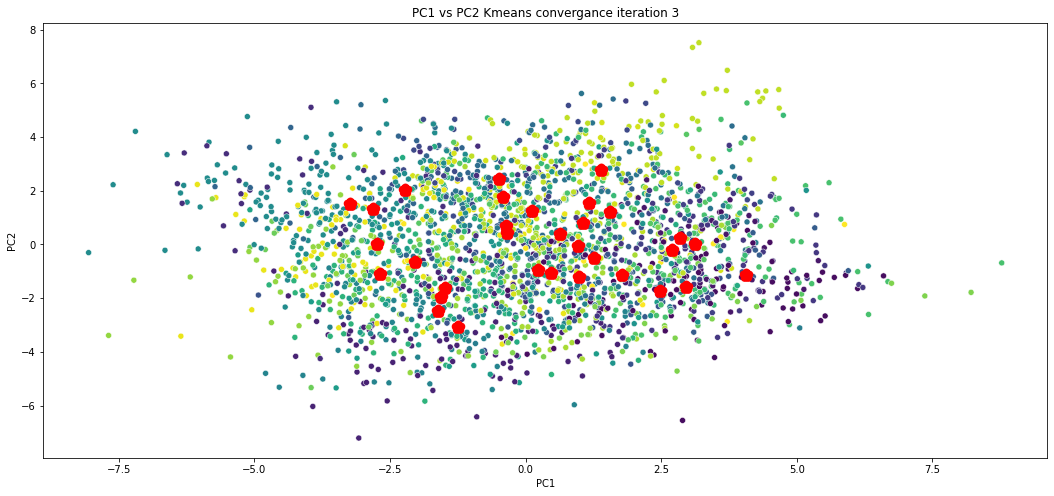

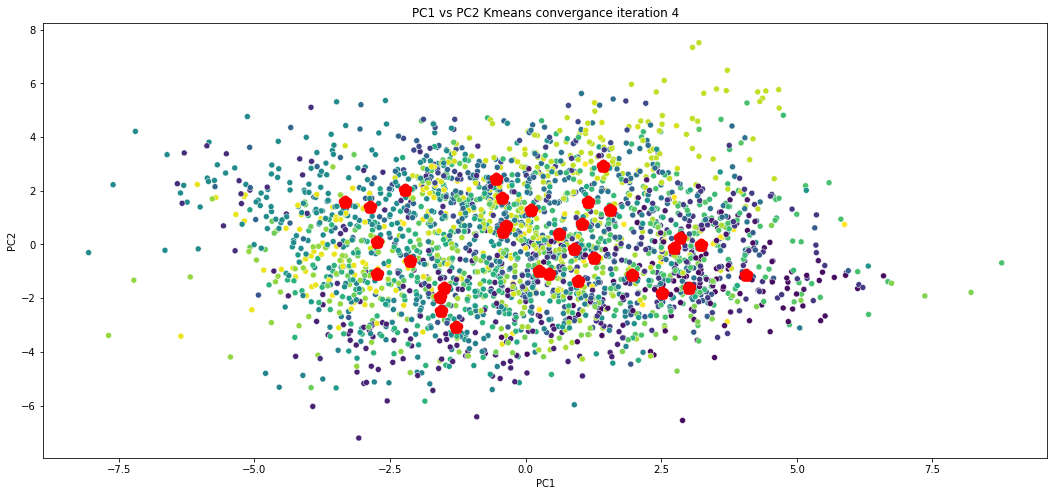

In [34]:
for _ in range(0,5):
    plt.figure(figsize=(18,8))
    model = KMeans(n_clusters=32, init='k-means++', n_init=5, max_iter=_+1, random_state=4)
    model.fit(principalDF)
    labels = model.labels_
    centroids = model.cluster_centers_
    sns.scatterplot(data=principalDF,x = "PC1", y = "PC2", c = labels)
    plt.scatter(data = pd.DataFrame(centroids[:,[0,1]], columns = ["one","two"]),x = "one", y = "two", marker='*', linewidths=8, color='r')
    plt.title(f"PC1 vs PC2 Kmeans convergance iteration {_}")

In [35]:
### Yes I can see that the clusters converge :) I am happy to see it work :) :)